## Librairies externes


#INF8225 PROJET H21
William Valiquette 1847812 

Rosanne Larocque   1872448

Marc-Olivier Bélanger 1840713 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

from keras.datasets import mnist

## Valeurs et fonctions globales

In [ ]:
n_categories = 10
img_size = 28

In [ ]:
# GPU
def gpu_warm_up(model, batch_size, img_size):
  '''
    util function making sure gpu is warmed up
    before any time measurement.
    https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f#:~:text=The%20Correct%20Way%20to%20Measure%20Inference%20Time%20of%20Deep%20Neural%20Networks,-Amnon%20Geifman&text=The%20network%20latency%20is%20one,few%20milliseconds%20to%20one%20second.
  '''
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  model = model.to(device)
  model = nn.DataParallel(model)
  # For convolutional layers shape must be: (batch_size, nb_chanels, height, width)
  # only 1 channel at input
  dummy_input = torch.randn(batch_size, 1, img_size, img_size, dtype=torch.float).to(device)

  #GPU-WARM-UP
  print("dummy: ", dummy_input.shape)
  for _ in range(10):
    _ = model(dummy_input).to(device)

  return model, device


## Lecture de données

In [ ]:
# to avoid the 503 error with lecunn's broken website... 
# https://stackoverflow.com/questions/66646604/http-error-503-service-unavailable-whan-trying-to-download-mnist-data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

def get_mnist_dataset(batch_size, val_percentage=0.1):
  dataset = MNIST(root = './', train=True, download=True, 
                  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))]))
  dataset_test = MNIST(root = './', train=False, download=True, 
                       transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))]))

  len_train = int(len(dataset) * (1.-val_percentage))
  len_val = len(dataset) - len_train
  dataset_train, dataset_val = random_split(dataset, [len_train, len_val])

  print(len_train)
  print(len_val)

  data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)

  data_loader_val   = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=2)
  data_loader_test  = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=2)

  return data_loader_train, data_loader_val, data_loader_test

--2021-04-29 15:11:21--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-29 15:11:22--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  6.44MB/s    in 6.4s    

2021-04-29 15:11:30 (5.20 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

## Réseau convolutif

### Définition et configuration du modèle

In [ ]:
hidden_sizes = [32, 64, 128]
n_epochs = 15
batch_size = 16
criterion = nn.CrossEntropyLoss()
lr = 0.0003

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_sizes[0], 3)
        self.conv2 = nn.Conv2d(hidden_sizes[0], hidden_sizes[1], 3)
        self.maxPool = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(hidden_sizes[1] * 12 * 12, hidden_sizes[2])
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_sizes[2], n_categories)
        self.out = nn.LogSoftmax()

    def forward(self, x):

        # convolutions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxPool(x)
        x = self.dropout1(x)

        # flatten
        x = x.view(x.size(0), -1)

        # dense
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x


model = Net()

### Entraînement et évaluation du modèle

In [ ]:
def get_accuracy(logit, target, batch_size):
    results = (torch.max(logit, 1)[1].view(target.size()).data == target.data)

    misclassified_idx = []
    for idx, correctness in enumerate(results):
      if not correctness: misclassified_idx.append(idx)
      if (len(misclassified_idx) == 5): break


    corrects = results.sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item(), misclassified_idx

def plot_losses_and_accuracies(train_values, validation_values, value_name='Loss'):
    epochs = range(n_epochs)
    plt.plot(epochs, train_values, 'g', label='Training')
    plt.plot(epochs, validation_values, 'b', label='validation')
    plt.title('Training and Validation ' + value_name)
    plt.xlabel('Epochs')
    plt.ylabel(value_name)
    plt.legend()
    plt.show()

def evaluate_model(dataloader, model, batch_size, device):
  model.eval()
  loss = 0.0
  acc = 0.0

  for inputs, labels in dataloader:
      outputs = model(inputs)
      labels = labels.to(device=device, dtype=torch.int64)
      batch_loss = criterion(outputs, labels)

      loss += batch_loss.detach().item()
      batch_acc, _ = get_accuracy(outputs, labels, batch_size)
      acc += batch_acc

  return loss, acc

def train(model, data_loader_train, data_loader_val, data_loader_test, lr = 0.001):

    model, device = gpu_warm_up(model, batch_size, img_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # keep track of acc and losses to plot later
    all_train_losses, all_train_acc = [], []
    all_val_losses, all_val_acc = [], []

    init_time = time.time()
    for epoch in range(n_epochs): 
        train_running_loss = 0.0
        train_acc = 0.0
        model.train()
        
        for inputs, labels in data_loader_train:
          
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            
            labels = labels.to(device=device, dtype=torch.int64)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.detach().item()
            batch_train_acc, _ = get_accuracy(outputs, labels, batch_size)
            train_acc += batch_train_acc


        val_loss, val_acc = evaluate_model(data_loader_val, model, batch_size, device)

        # Save and show results
        all_train_losses.append(train_running_loss / len(data_loader_train))
        all_train_acc.append(train_acc/len(data_loader_train))
        all_val_losses.append(val_loss / len(data_loader_val))
        all_val_acc.append(val_acc/len(data_loader_val))
        print('Epoch:  %d | Train Loss: %.4f | Train Accuracy: %.2f | Val Loss: %.4f | Val Accuracy: %.2f'
              %(epoch, train_running_loss / len(data_loader_train), train_acc/len(data_loader_train),
                val_loss / len(data_loader_val), val_acc/len(data_loader_val)
              ))
        
    final_time = time.time() # end of training
      
    # Calculate test accuracy and inference time
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((len(data_loader_test), 1))
    test_acc = 0.0

    for i, data in enumerate(data_loader_test):
        (inputs, labels) = data

        starter.record()
        outputs = model(inputs)
        ender.record()
        labels = labels.to(device=device, dtype=torch.int64)
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[i] = curr_time/len(labels)

        batch_test_acc, misclassified = get_accuracy(outputs, labels, batch_size)
        test_acc += batch_test_acc



    print('Test Accuracy: %.2f'%(test_acc/len(data_loader_test)))
    print('Training Time: %.2f seconds'%(final_time - init_time))
    print('Inference Time: %.2f seconds'%(np.sum(timings) / len(data_loader_test)))
    plot_losses_and_accuracies(all_train_losses, all_val_losses, value_name='Loss')
    plot_losses_and_accuracies(all_train_acc, all_val_acc, value_name='Accuracy')

In [ ]:
data_loader_train, data_loader_val, data_loader_test = get_mnist_dataset(batch_size=batch_size)

54000
6000


dummy:  torch.Size([16, 1, 28, 28])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  0 | Train Loss: 0.2462 | Train Accuracy: 92.73 | Val Loss: 0.0561 | Val Accuracy: 98.35
Epoch:  1 | Train Loss: 0.0997 | Train Accuracy: 97.05 | Val Loss: 0.0463 | Val Accuracy: 98.62
Epoch:  2 | Train Loss: 0.0724 | Train Accuracy: 97.86 | Val Loss: 0.0392 | Val Accuracy: 98.80
Epoch:  3 | Train Loss: 0.0627 | Train Accuracy: 98.18 | Val Loss: 0.0352 | Val Accuracy: 98.97
Epoch:  4 | Train Loss: 0.0510 | Train Accuracy: 98.41 | Val Loss: 0.0383 | Val Accuracy: 98.98
Epoch:  5 | Train Loss: 0.0444 | Train Accuracy: 98.64 | Val Loss: 0.0319 | Val Accuracy: 99.07
Epoch:  6 | Train Loss: 0.0386 | Train Accuracy: 98.74 | Val Loss: 0.0328 | Val Accuracy: 99.07
Epoch:  7 | Train Loss: 0.0336 | Train Accuracy: 98.95 | Val Loss: 0.0315 | Val Accuracy: 99.08
Epoch:  8 | Train Loss: 0.0306 | Train Accuracy: 99.02 | Val Loss: 0.0385 | Val Accuracy: 99.12
Epoch:  9 | Train Loss: 0.0258 | Train Accuracy: 99.13 | Val Loss: 0.0302 | Val Accuracy: 99.18
Epoch:  10 | Train Loss: 0.0257 | Train 

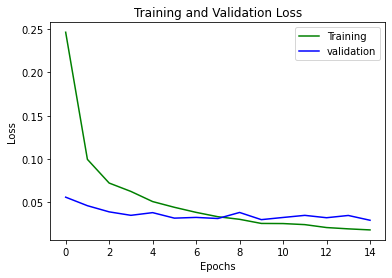

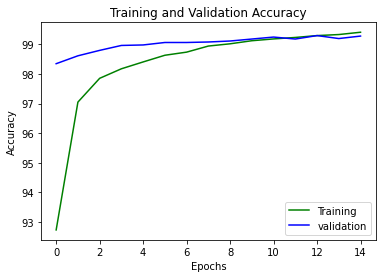

In [ ]:
train(model, data_loader_train, data_loader_val, data_loader_test, lr=lr)

## Arbre de régression souple standard

### Définition et configuration du modèle

Le code est fortement inspiré et adapté de ce répertoire: https://github.com/kimhc6028/soft-decision-tree/blob/master/model.py

In [ ]:
def get_model_predictions(model, inputs, softmax = nn.Softmax(1)):
  inputs = inputs.cuda()
  outputs = model(inputs)
  outputs = outputs.cpu()
  return softmax(outputs)

In [ ]:
class Leaf():
  def __init__(self, nb_classes):
      device = torch.device('cpu')
      self.distribution = nn.Parameter(torch.rand(nb_classes).to(device))
      self.softmax = nn.Softmax()
      self.path_prob = 0
      

  def forward(self):
      # simply softmax of the learned distribution vector
      return(self.softmax(self.distribution.view(1,-1)))


class Node():
  def __init__(self, depth, nb_classes, input_size, lmbda):
    self.input_size = input_size
    self.nb_classes = nb_classes
    device = torch.device('cpu')

    self.fc = nn.Linear(self.input_size, 1)
    self.beta = nn.Parameter(torch.rand(1).to(device)) # inverse temperature

    # to compute penalty
    self.root_lmbda = lmbda
    self.lmbda = lmbda * 2 ** (-depth)
    self.alpha = 0 # will be set according to inputs

    if depth > 0:
      self.children = self.build_children(depth)  
    else:
      self.children = [Leaf(nb_classes), Leaf(nb_classes)]
  

  def build_children(self, depth):
    return [Node(depth - 1, self.nb_classes, self.input_size, self.root_lmbda), 
            Node(depth - 1, self.nb_classes, self.input_size, self.root_lmbda)]


  def forward(self, x):
    return(torch.sigmoid(self.beta*self.fc(x)))


class SoftDecisionTree(nn.Module):
  def __init__(self, depth, nb_classes, input_size, learning_rate = 1e-2, weight_decay = 5e-4, lmbda = 0.1):
    super(SoftDecisionTree, self).__init__()
    # output_dim
    self.nb_classes = nb_classes

    #input_dim
    self.input_size = input_size

    # build tree
    self.root = Node(depth - 1, self.nb_classes, self.input_size, lmbda)
    self.nodes = []
    self.leaves = []
    self.is_distillated = False

    # set Torch optimizer's parameters
    self.collect_parameters()
    self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)

    self.device = torch.device('cpu')

  
  def collect_parameters(self):
    nodes = [self.root]
    self.param_list = nn.ParameterList()
    self.module_list = nn.ModuleList()
    while nodes:
      node = nodes.pop(0)
      if isinstance(node, Leaf):
        self.param_list.append(node.distribution)
        self.leaves.append(node)
      else:
        nodes.append(node.children[0])
        nodes.append(node.children[1])
        self.module_list.append(node.fc)
        self.nodes.append(node)


  def forward(self, current_node, inputs, path_prob):
    if isinstance(current_node, Leaf): 
      current_node.path_prob = path_prob
      return # end of recursion at a leaf
      
    # set params for penalty
    prob = current_node.forward(inputs)
    current_node.alpha = torch.sum(prob * path_prob) / torch.sum(path_prob)

    # Left Children -> prob = activation 
    self.forward(current_node.children[0], inputs, prob * path_prob)
    # Right children -> prob = 1 - activation
    self.forward(current_node.children[1], inputs, (1-prob) * path_prob)


  def get_loss(self, targets):
    loss = 0
    for leaf in self.leaves:
      Q = torch.transpose(leaf.forward(), 0, 1).double()
      loss_l = torch.matmul(targets.double(), torch.log(Q))
      loss += leaf.path_prob * loss_l
    
    C = self.get_penalty()
    return -loss.mean() + C


  def get_penalty(self):
    C = 0
    for node in self.nodes:
      C += -node.lmbda * 0.5 *(torch.log(node.alpha) + torch.log(1-node.alpha))

    return C


  def predict_classes(self, batch_size):
    chosen_predictors = [max(self.leaves, key=lambda leaf: leaf.path_prob[i])  for i in range(batch_size)]
    predictions = [predictor.forward() for predictor in chosen_predictors]

    return [np.argmax(pred.detach().cpu().numpy()) for pred in predictions]


  def onehot_coding(self, target):
    target_onehot = torch.FloatTensor(target.size()[0], self.nb_classes).to(self.device)
    target_onehot.data.zero_()
    target_onehot.scatter_(1, target.view(-1, 1), 1.0)
    return target_onehot


  def train_epoch(self, train_loader, epoch_nb):
    accuracies = []
    losses = []
    for inputs, targets in train_loader:

      inputs = inputs.to(self.device)
      targets = targets.to(self.device)

      # if training distillated tree, use NN predictions
      targets = get_model_predictions(model, inputs) if self.is_distillated else self.onehot_coding(targets)

      inputs = inputs.view(len(inputs), -1)   
      self.optimizer.zero_grad()

      # training
      ones = torch.ones((len(inputs), 1)).to(self.device)
      self.forward(self.root, inputs, ones)
      loss = self.get_loss(targets)
      losses.append(loss.detach().cpu().numpy())

      # gradient step
      loss.backward()
      self.optimizer.step()

      # keep track of accuracy
      predictions = self.predict_classes(len(inputs))
      errors = np.count_nonzero(predictions - torch.argmax(targets, dim=1).detach().cpu().numpy())
      accuracies.append(100. * (1 -  errors / len(inputs)))

    return np.mean(accuracies), np.mean(losses)


  def evaluate_tree(self, data_loader):
    losses = []
    accuracies = []
    self.eval()
    for inputs, targets in data_loader:

      inputs = inputs.to(self.device)
      targets = targets.to(self.device)

      targets = get_model_predictions(model, inputs) if self.is_distillated else self.onehot_coding(targets)

      inputs = inputs.view(len(inputs), -1)   
      self.forward(self.root, inputs, torch.ones((len(inputs), 1)))

      loss = self.get_loss(targets)
      losses.append(loss.detach().cpu().numpy())

      predictions = self.predict_classes(len(inputs))
      errors = np.count_nonzero(predictions - torch.argmax(targets, dim=1).detach().cpu().numpy())
      accuracies.append(100. * (1 -  errors / len(inputs)))

    return np.mean(accuracies), np.mean(losses)

### Entraînement et évaluation

In [ ]:
def train_soft_tree(soft_tree, data_loader_train, data_loader_val, data_loader_test):
  for epoch in range(nb_epochs):
    acc, loss = soft_tree.train_epoch(data_loader_train, epoch)
    val_acc, val_loss = soft_tree.evaluate_tree(data_loader_val)
    print(f"Epoch: {epoch} Trg accuracy: {acc:.3f} Trg loss: {loss:.3f} Val accuracy: {val_acc:.3f} Val loss: {val_loss:.3f}")
 
  test_acc, test_loss = soft_tree.evaluate_tree(data_loader_test)
  print(f"Test Accuracy: {test_acc:.3f} Test Loss: {test_loss:.3f}")

In [ ]:
batch_size = 128
lr = 1e-2
lmbda = 0.01
weight_decay = 5e-4
nb_epochs = 20
depth = 7

data_loader_train, data_loader_val, data_loader_test = get_mnist_dataset(batch_size)
soft_tree = SoftDecisionTree(depth, n_categories, img_size*img_size, lr, weight_decay, lmbda)

train_soft_tree(soft_tree, data_loader_train, data_loader_val, data_loader_test)

54000
6000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Epoch: 0 Trg accuracy: 82.905 Trg loss: 1.581 Val accuracy: 86.078 Val loss: 1.261
Epoch: 1 Trg accuracy: 87.942 Trg loss: 1.221 Val accuracy: 88.186 Val loss: 1.212
Epoch: 2 Trg accuracy: 88.643 Trg loss: 1.193 Val accuracy: 88.255 Val loss: 1.201
Epoch: 3 Trg accuracy: 89.005 Trg loss: 1.188 Val accuracy: 88.585 Val loss: 1.193
Epoch: 4 Trg accuracy: 89.045 Trg loss: 1.180 Val accuracy: 88.034 Val loss: 1.212
Epoch: 5 Trg accuracy: 89.042 Trg loss: 1.177 Val accuracy: 88.103 Val loss: 1.226
Epoch: 6 Trg accuracy: 89.120 Trg loss: 1.177 Val accuracy: 88.540 Val loss: 1.201
Epoch: 7 Trg accuracy: 89.476 Trg loss: 1.176 Val accuracy: 88.645 Val loss: 1.190
Epoch: 8 Trg accuracy: 89.408 Trg loss: 1.172 Val accuracy: 88.621 Val loss: 1.190
Epoch: 9 Trg accuracy: 89.664 Trg loss: 1.172 Val accuracy: 88.915 Val loss: 1.200
Epoch: 10 Trg accuracy: 89.838 Trg loss: 1.170 Val accuracy: 89.815 Val loss: 1.188
Epoch: 11 Trg accuracy: 90.071 Trg loss: 1.172 Val accuracy: 89.585 Val loss: 1.189
Ep

## Distillation du réseau en arbre souple

### Construction de la distribution créée par le réseau

In [ ]:
# same hyper parameters as the regular soft tree, to assure valid comparison
distillated_tree = SoftDecisionTree(depth, n_categories, img_size*img_size, lr, weight_decay)
distillated_tree.is_distillated = True

train_soft_tree(distillated_tree, data_loader_train, data_loader_val, data_loader_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Epoch: 0 Trg accuracy: 81.662 Trg loss: 7.080 Val accuracy: 88.158 Val loss: 6.772
Epoch: 1 Trg accuracy: 89.164 Trg loss: 6.826 Val accuracy: 88.409 Val loss: 6.795
Epoch: 2 Trg accuracy: 89.708 Trg loss: 6.713 Val accuracy: 88.892 Val loss: 6.686
Epoch: 3 Trg accuracy: 89.803 Trg loss: 6.663 Val accuracy: 89.758 Val loss: 6.663
Epoch: 4 Trg accuracy: 89.783 Trg loss: 6.656 Val accuracy: 89.822 Val loss: 6.673
Epoch: 5 Trg accuracy: 89.993 Trg loss: 6.660 Val accuracy: 90.523 Val loss: 6.697
Epoch: 6 Trg accuracy: 90.461 Trg loss: 6.707 Val accuracy: 89.559 Val loss: 6.829
Epoch: 7 Trg accuracy: 90.481 Trg loss: 6.845 Val accuracy: 89.898 Val loss: 6.762
Epoch: 8 Trg accuracy: 90.512 Trg loss: 6.681 Val accuracy: 89.784 Val loss: 6.681
Epoch: 9 Trg accuracy: 90.385 Trg loss: 6.656 Val accuracy: 89.374 Val loss: 6.678
Epoch: 10 Trg accuracy: 90.634 Trg loss: 6.642 Val accuracy: 90.036 Val loss: 6.669
Epoch: 11 Trg accuracy: 90.512 Trg loss: 6.650 Val accuracy: 89.972 Val loss: 6.671
Ep